# Week 8 Supervised Learning

## Practicum 8-1

PR8-1: Regressiemodellen in Machine Learning. Great Outdoors wil graag weten hoeveel zij gaat verkopen op basis van een set onafhankelijke variabelen. Daarom wil zij een model trainen op basis van reeds bekende data, zodat deze volgend jaar in gebruik kan worden genomen. Je doet dus het volgende met de reeds bekende data:

* Bedenk met welke onafhankelijke variabelen, die ook uit meerdere databasetabellen kunnen komen, dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
* Pas waar nodig Dummy Encoding toe.
* Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
* Train het regressiemodel.
* Evalueer de performance van je getrainde regressiemodel.

### Tables

Hieronder zie je de tabellen die we gaan gebruiken voor deze practicumopdracht van 8-1.

In [96]:
# order_details
# order_header
# product

### Imports

Hier staan alle imports die gebruikt zullen worden voor de practicumopdrachten 8-1.

In [97]:
import sqlite3 as sql
import warnings as warn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from typing import Any
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
warn.filterwarnings("ignore")

### SQLite connections and CSV-files

Hier maken we de connectie naar de SQLite Databases en roepen we de CSV bestanden aan.

In [98]:
conn = sql.connect("Great_Outdoors_Data_SQLite/go_sales.sqlite")

go_sales_inventory_levelsdata = pd.read_csv("Great_Outdoors_Data_SQLite/GO_SALES_INVENTORY_LEVELSData.csv", sep=",")
go_sales_product_forecastdata = pd.read_csv("Great_Outdoors_Data_SQLite/GO_SALES_PRODUCT_FORECASTData.csv", sep=",")

### Show the necassery tables

We kunnen snel de inhoud zien van de tabellen.

In [99]:
order_details = pd.read_sql_query(f"SELECT * FROM order_details", conn) # 8 columns
order_header = pd.read_sql_query(f"SELECT * FROM order_header", conn) # 9 columns
product = pd.read_sql_query(f"SELECT * FROM product", conn) # 10 columns
product # 27 columns

,PRODUCT_NUMBER,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,TRIAL888
0,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",T
1,10,15-2-2011,1,10,.4,P10CE1CG1.jpg,EN,TrailChef Utensils,"Spoon, fork and knife set made of a light yet ...",T
2,100,15-2-2011,17,3,.5,P100OP4FA17.jpg,EN,Insect Bite Relief,The Insect Bite Relief helps the itching and s...,T
3,101,15-12-2019,18,305.54,.43,P101GE5IR18.jpg,EN,Hailstorm Steel Irons,Iron is 17-4 stainless steel. Shafts are grap...,T
4,102,10-12-2019,18,380.95,.51,P102GE5IR18.jpg,EN,Hailstorm Titanium Irons,Made entirely of pure titanium. The ultimate i...,T
...,...,...,...,...,...,...,...,...,...,...
110,95,15-2-2011,16,3,.5,P91OP4SS16.jpg,EN,Sun Shield,"PABA free sunscreen, SPF 30, poison oak and iv...",T
111,96,15-2-2011,17,16.43,.28,P96OP4FA17.jpg,EN,Compact Relief Kit,A personal first aid kit is recommended for ev...,T
112,97,5-3-2013,17,25,.28,P96OP4FA17.jpg,EN,Deluxe Family Relief Kit,A complete medical kit suitable for families w...,T
113,98,15-2-2011,17,3,.5,P98OP4FA17.jpg,EN,Calamine Relief,Use the Calamine Relief for allergic skin reac...,T


### Merge the tables

Hier voegen we de tabellen samen, zodat we betere voorspellingen kunnen maken.

In [100]:
#Here we display all the columns
pd.set_option("display.max_columns", None)

df = product.merge(order_details, on="PRODUCT_NUMBER").merge(order_header, on="ORDER_NUMBER")
df

,PRODUCT_NUMBER,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,TRIAL888,ORDER_DETAIL_CODE,ORDER_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,TRIAL879,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,TRIAL885
0,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",T,100085,8474,40,4.01,6.03,6.03,T,Naranco de Bulnes,330,315,94,29,2021-07-08,4,T
1,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",T,100086,8470,40,4.01,6.03,6.03,T,Naranco de Bulnes,329,314,95,29,2021-10-06,4,T
2,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",T,100087,8464,48,4.01,6.03,6.03,T,Naranco de Bulnes,327,312,94,29,2021-09-09,4,T
3,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",T,100088,9254,66,4.01,6.03,6.03,T,Naranco de Bulnes,327,312,94,29,2021-10-23,5,T
4,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",T,100089,8472,88,4.01,6.03,6.03,T,Naranco de Bulnes,330,315,94,29,2021-03-15,5,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,99,15-2-2011,17,2,.6,P99OP4FA17.jpg,EN,Aloe Relief,"Perfect for minor burns and sunburn, the aloe ...",T,98478,8210,30,1.97,4.94,4.94,T,Extra Sport,291,288,24,9,2021-05-31,5,T
43059,99,15-2-2011,17,2,.6,P99OP4FA17.jpg,EN,Aloe Relief,"Perfect for minor burns and sunburn, the aloe ...",T,99566,8246,20,2,5,3.95,T,Beter Buitenleven,288,285,26,9,2022-05-20,7,T
43060,99,15-2-2011,17,2,.6,P99OP4FA17.jpg,EN,Aloe Relief,"Perfect for minor burns and sunburn, the aloe ...",T,99567,8239,18,2,5,5,T,Beter Buitenleven,286,283,23,9,2022-04-06,7,T
43061,99,15-2-2011,17,2,.6,P99OP4FA17.jpg,EN,Aloe Relief,"Perfect for minor burns and sunburn, the aloe ...",T,99568,8270,26,2,5,5,T,Sportworld,272,269,22,9,2022-06-25,2,T


### Drop unnecassary columns 1/2

Hier verwijderen we de nutteloze TRIAL kolommen.

In [101]:
df = df[df.columns.drop(list(df.filter(regex="TRIAL")))]
df

,PRODUCT_NUMBER,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,ORDER_DETAIL_CODE,ORDER_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE
0,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",100085,8474,40,4.01,6.03,6.03,Naranco de Bulnes,330,315,94,29,2021-07-08,4
1,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",100086,8470,40,4.01,6.03,6.03,Naranco de Bulnes,329,314,95,29,2021-10-06,4
2,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",100087,8464,48,4.01,6.03,6.03,Naranco de Bulnes,327,312,94,29,2021-09-09,4
3,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",100088,9254,66,4.01,6.03,6.03,Naranco de Bulnes,327,312,94,29,2021-10-23,5
4,1,15-2-2011,1,4,.33,P01CE1CG1.jpg,EN,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",100089,8472,88,4.01,6.03,6.03,Naranco de Bulnes,330,315,94,29,2021-03-15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,99,15-2-2011,17,2,.6,P99OP4FA17.jpg,EN,Aloe Relief,"Perfect for minor burns and sunburn, the aloe ...",98478,8210,30,1.97,4.94,4.94,Extra Sport,291,288,24,9,2021-05-31,5
43059,99,15-2-2011,17,2,.6,P99OP4FA17.jpg,EN,Aloe Relief,"Perfect for minor burns and sunburn, the aloe ...",99566,8246,20,2,5,3.95,Beter Buitenleven,288,285,26,9,2022-05-20,7
43060,99,15-2-2011,17,2,.6,P99OP4FA17.jpg,EN,Aloe Relief,"Perfect for minor burns and sunburn, the aloe ...",99567,8239,18,2,5,5,Beter Buitenleven,286,283,23,9,2022-04-06,7
43061,99,15-2-2011,17,2,.6,P99OP4FA17.jpg,EN,Aloe Relief,"Perfect for minor burns and sunburn, the aloe ...",99568,8270,26,2,5,5,Sportworld,272,269,22,9,2022-06-25,2


### Delete unnecassary columns 2/2

Hier verwijderen we kolommen die geen waarde hebben op het regressiemodel.

In [102]:
df = df.drop(columns=["RETAILER_NAME", "PRODUCT_IMAGE", "PRODUCT_NAME", "DESCRIPTION", "LANGUAGE"])
df

,PRODUCT_NUMBER,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,ORDER_DETAIL_CODE,ORDER_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE
0,1,15-2-2011,1,4,.33,100085,8474,40,4.01,6.03,6.03,330,315,94,29,2021-07-08,4
1,1,15-2-2011,1,4,.33,100086,8470,40,4.01,6.03,6.03,329,314,95,29,2021-10-06,4
2,1,15-2-2011,1,4,.33,100087,8464,48,4.01,6.03,6.03,327,312,94,29,2021-09-09,4
3,1,15-2-2011,1,4,.33,100088,9254,66,4.01,6.03,6.03,327,312,94,29,2021-10-23,5
4,1,15-2-2011,1,4,.33,100089,8472,88,4.01,6.03,6.03,330,315,94,29,2021-03-15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,99,15-2-2011,17,2,.6,98478,8210,30,1.97,4.94,4.94,291,288,24,9,2021-05-31,5
43059,99,15-2-2011,17,2,.6,99566,8246,20,2,5,3.95,288,285,26,9,2022-05-20,7
43060,99,15-2-2011,17,2,.6,99567,8239,18,2,5,5,286,283,23,9,2022-04-06,7
43061,99,15-2-2011,17,2,.6,99568,8270,26,2,5,5,272,269,22,9,2022-06-25,2


### Split the date into year and month

We maken een nieuwe kolom voor het jaar en de maand, zodat we die dan kunnen gebruiken en weergeven.

In [103]:
# Split date in year and month, creating new columns "ORDER_DATE_YEAR" and "ORDER_DATE_MONTH"
df["ORDER_DATE"] = pd.to_datetime(df["ORDER_DATE"])
df["ORDER_DATE_YEAR"] = pd.DatetimeIndex(df["ORDER_DATE"]).year
df["ORDER_DATE_MONTH"] = pd.DatetimeIndex(df["ORDER_DATE"]).month
df

,PRODUCT_NUMBER,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,ORDER_DETAIL_CODE,ORDER_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,ORDER_DATE_YEAR,ORDER_DATE_MONTH
0,1,15-2-2011,1,4,.33,100085,8474,40,4.01,6.03,6.03,330,315,94,29,2021-07-08,4,2021,7
1,1,15-2-2011,1,4,.33,100086,8470,40,4.01,6.03,6.03,329,314,95,29,2021-10-06,4,2021,10
2,1,15-2-2011,1,4,.33,100087,8464,48,4.01,6.03,6.03,327,312,94,29,2021-09-09,4,2021,9
3,1,15-2-2011,1,4,.33,100088,9254,66,4.01,6.03,6.03,327,312,94,29,2021-10-23,5,2021,10
4,1,15-2-2011,1,4,.33,100089,8472,88,4.01,6.03,6.03,330,315,94,29,2021-03-15,5,2021,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,99,15-2-2011,17,2,.6,98478,8210,30,1.97,4.94,4.94,291,288,24,9,2021-05-31,5,2021,5
43059,99,15-2-2011,17,2,.6,99566,8246,20,2,5,3.95,288,285,26,9,2022-05-20,7,2022,5
43060,99,15-2-2011,17,2,.6,99567,8239,18,2,5,5,286,283,23,9,2022-04-06,7,2022,4
43061,99,15-2-2011,17,2,.6,99568,8270,26,2,5,5,272,269,22,9,2022-06-25,2,2022,6


### Rename the columns from inventory levelsdata

We hernoemen de kolommen van inventaris levelsdata, zodat dit een betere benaming heeft en beter samen te voegen is.

In [104]:
# Rename "INVENTORY_MONTH" to "MONTH", "INVENTORY_YEAR" to "YEAR" and "INVENTORY_COUNT" to "INVENTORY_QUANTITY"
inventory_levelsdata = go_sales_inventory_levelsdata.rename(columns={"INVENTORY_MONTH": "MONTH", "INVENTORY_YEAR": "YEAR", "INVENTORY_COUNT": "INVENTORY_QUANTITY"})
inventory_levelsdata

,YEAR,MONTH,PRODUCT_NUMBER,INVENTORY_QUANTITY
0,2021,4,48,1932
1,2021,4,49,1400
2,2021,4,50,21705
3,2021,4,51,9710
4,2021,4,52,5616
...,...,...,...,...
3883,2022,12,111,1128
3884,2022,12,112,7810
3885,2022,12,113,3485
3886,2022,12,114,350


### Merge the columns from inventory levelsdata with product forecastdata

We voegen de kolommen uit de inventaris levelsdata met product voorspellingdata samen.

In [105]:
# Merge the product forecastdata with the inventory levelsdata
product_forecastdata = go_sales_product_forecastdata.merge(inventory_levelsdata, on=["PRODUCT_NUMBER", "YEAR", "MONTH"])
product_forecastdata

,PRODUCT_NUMBER,YEAR,MONTH,EXPECTED_VOLUME,INVENTORY_QUANTITY
0,44,2022,12,383,8922
1,45,2021,1,80,1858
2,45,2021,2,51,1930
3,45,2021,3,214,1856
4,45,2021,4,300,1676
...,...,...,...,...,...
3867,115,2022,8,282,6654
3868,115,2022,9,920,5634
3869,115,2022,10,1081,4488
3870,115,2022,11,398,4108


### Convert columns to a numeric datatype

We zullen hier verschillende kolommen naar numerieke waarden omzetten.

In [106]:
# Convert product_number to int and production_cost and margin to float
df["PRODUCT_NUMBER"] = product["PRODUCT_NUMBER"].astype(int)
df["PRODUCTION_COST"] = product["PRODUCTION_COST"].astype(float)
df["MARGIN"] = product["MARGIN"].astype(float)
df.dtypes

PRODUCT_NUMBER                  float64
INTRODUCTION_DATE                object
PRODUCT_TYPE_CODE                object
PRODUCTION_COST                 float64
MARGIN                          float64
ORDER_DETAIL_CODE                object
ORDER_NUMBER                     object
QUANTITY                          int64
UNIT_COST                        object
UNIT_PRICE                       object
UNIT_SALE_PRICE                  object
RETAILER_SITE_CODE               object
RETAILER_CONTACT_CODE            object
SALES_STAFF_CODE                 object
SALES_BRANCH_CODE                object
ORDER_DATE               datetime64[ns]
ORDER_METHOD_CODE                object
ORDER_DATE_YEAR                   int32
ORDER_DATE_MONTH                  int32
dtype: object

### Merge everything to the DataFrame

Nu kunnen we alle go_sales CSV's bestanden samenvoegen met het DataFrame met order_details, order_header en product.

In [107]:
# Concat product_forecastdata with df
#df = pd.concat([product_forecastdata, df], axis=1).drop_duplicates()
df = product_forecastdata.merge(df, on="PRODUCT_NUMBER").drop_duplicates()
df = df.fillna(0)
df

,PRODUCT_NUMBER,YEAR,MONTH,EXPECTED_VOLUME,INVENTORY_QUANTITY,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,ORDER_DETAIL_CODE,ORDER_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,ORDER_DATE_YEAR,ORDER_DATE_MONTH
0,44,2022,12,383,8922,15-2-2011,1,231.11,0.33,104616,9145,72,4,6,6,421,430,116,37,2022-07-30,3,2022,7
1,45,2021,1,80,1858,15-2-2011,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,2020-11-16,4,2020,11
2,45,2021,2,51,1930,15-2-2011,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,2020-11-16,4,2020,11
3,45,2021,3,214,1856,15-2-2011,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,2020-11-16,4,2020,11
4,45,2021,4,300,1676,15-2-2011,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,2020-11-16,4,2020,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3867,115,2022,8,282,6654,15-2-2011,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,2020-10-16,5,2020,10
3868,115,2022,9,920,5634,15-2-2011,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,2020-10-16,5,2020,10
3869,115,2022,10,1081,4488,15-2-2011,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,2020-10-16,5,2020,10
3870,115,2022,11,398,4108,15-2-2011,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,2020-10-16,5,2020,10


### Convert the columns to numeric types

Alle kolommen worden naar numerieke waardes omgezet met een check of ze numeriek zijn, zodat ze bruikbaar zijn voor de regressiemodellen.

In [108]:
# Convert all remaining columns to numeric types
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column] = pd.to_numeric(df[column], errors="coerce")

df.dtypes

PRODUCT_NUMBER                    int64
YEAR                              int64
MONTH                             int64
EXPECTED_VOLUME                   int64
INVENTORY_QUANTITY                int64
INTRODUCTION_DATE                object
PRODUCT_TYPE_CODE                object
PRODUCTION_COST                 float64
MARGIN                          float64
ORDER_DETAIL_CODE                object
ORDER_NUMBER                     object
QUANTITY                          int64
UNIT_COST                        object
UNIT_PRICE                       object
UNIT_SALE_PRICE                  object
RETAILER_SITE_CODE               object
RETAILER_CONTACT_CODE            object
SALES_STAFF_CODE                 object
SALES_BRANCH_CODE                object
ORDER_DATE               datetime64[ns]
ORDER_METHOD_CODE                object
ORDER_DATE_YEAR                   int32
ORDER_DATE_MONTH                  int32
dtype: object

### We create dummies to perform One-hot encoding

We maken het jaartal en de maand naar dummies, zodat ze dom worden en er meer kolommen zijn.

In [109]:
df_year = pd.get_dummies(df["ORDER_DATE_YEAR"], prefix="YEAR")
df_month = pd.get_dummies(df["ORDER_DATE_MONTH"], prefix="MONTH")
df = pd.concat([df, df_year, df_month], axis=1)
df

,PRODUCT_NUMBER,YEAR,MONTH,EXPECTED_VOLUME,INVENTORY_QUANTITY,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,ORDER_DETAIL_CODE,ORDER_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,ORDER_DATE_YEAR,ORDER_DATE_MONTH,YEAR_2020,YEAR_2021,YEAR_2022,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,44,2022,12,383,8922,15-2-2011,1,231.11,0.33,104616,9145,72,4,6,6,421,430,116,37,2022-07-30,3,2022,7,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
1,45,2021,1,80,1858,15-2-2011,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,2020-11-16,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,45,2021,2,51,1930,15-2-2011,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,2020-11-16,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,45,2021,3,214,1856,15-2-2011,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,2020-11-16,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,45,2021,4,300,1676,15-2-2011,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,2020-11-16,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3867,115,2022,8,282,6654,15-2-2011,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,2020-10-16,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3868,115,2022,9,920,5634,15-2-2011,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,2020-10-16,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3869,115,2022,10,1081,4488,15-2-2011,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,2020-10-16,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3870,115,2022,11,398,4108,15-2-2011,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,2020-10-16,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False


### Deleting columns with date values

We verwijderen de kolommen die datums bevatten, zodat deze geen fouten kunnen veroorzaken bij het trainen en testen van de data.

In [110]:
# We have to drop the columns "INTRODUCTION_DATE" and "ORDER_DATE" precisely here, because else there will be an error if it's placed
# below the horizontal and vertical cut. Putting it above where we convert the columns to numeric types is possible, but not advised.
df = df.drop(columns=["INTRODUCTION_DATE", "ORDER_DATE"])
df

,PRODUCT_NUMBER,YEAR,MONTH,EXPECTED_VOLUME,INVENTORY_QUANTITY,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,ORDER_DETAIL_CODE,ORDER_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_METHOD_CODE,ORDER_DATE_YEAR,ORDER_DATE_MONTH,YEAR_2020,YEAR_2021,YEAR_2022,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,44,2022,12,383,8922,1,231.11,0.33,104616,9145,72,4,6,6,421,430,116,37,3,2022,7,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
1,45,2021,1,80,1858,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,45,2021,2,51,1930,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,45,2021,3,214,1856,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,45,2021,4,300,1676,1,383.32,0.33,106031,9370,76,4.38,6.59,6.59,391,399,110,35,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3867,115,2022,8,282,6654,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3868,115,2022,9,920,5634,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3869,115,2022,10,1081,4488,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3870,115,2022,11,398,4108,1,5.00,0.50,101245,8551,46,4.38,6.59,6.59,271,268,27,15,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False


### Horizontal and vertical cut

We snijden horizontaal en verticaal, zodat we het model kunnen trainen en testen.

In [111]:
X = df.drop(columns=["QUANTITY"])
y = df["QUANTITY"]
X

,PRODUCT_NUMBER,YEAR,MONTH,EXPECTED_VOLUME,INVENTORY_QUANTITY,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,ORDER_DETAIL_CODE,ORDER_NUMBER,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_METHOD_CODE,ORDER_DATE_YEAR,ORDER_DATE_MONTH,YEAR_2020,YEAR_2021,YEAR_2022,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,44,2022,12,383,8922,1,231.11,0.33,104616,9145,4,6,6,421,430,116,37,3,2022,7,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
1,45,2021,1,80,1858,1,383.32,0.33,106031,9370,4.38,6.59,6.59,391,399,110,35,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,45,2021,2,51,1930,1,383.32,0.33,106031,9370,4.38,6.59,6.59,391,399,110,35,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,45,2021,3,214,1856,1,383.32,0.33,106031,9370,4.38,6.59,6.59,391,399,110,35,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,45,2021,4,300,1676,1,383.32,0.33,106031,9370,4.38,6.59,6.59,391,399,110,35,4,2020,11,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3867,115,2022,8,282,6654,1,5.00,0.50,101245,8551,4.38,6.59,6.59,271,268,27,15,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3868,115,2022,9,920,5634,1,5.00,0.50,101245,8551,4.38,6.59,6.59,271,268,27,15,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3869,115,2022,10,1081,4488,1,5.00,0.50,101245,8551,4.38,6.59,6.59,271,268,27,15,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3870,115,2022,11,398,4108,1,5.00,0.50,101245,8551,4.38,6.59,6.59,271,268,27,15,5,2020,10,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False


### Train and test data

Hier kunnen we eindelijk de data trainen en testen die we nodig hebben.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model: LinearRegression = LinearRegression()
model.fit(X_train, y_train)
model

LinearRegression()

### Predict the model

We kunnen het model met de test data van de onafhankelijke waarde voorspellen.

In [113]:
y_pred: Any = model.predict(X_test)
y_pred

array([ 83.07282173, 136.33570528,  42.74133527,  47.48794898,
        83.17182167,  49.48682794,  50.52441739,  55.45099162,
        83.18102848,  99.75416167,  51.01400826,  76.53116562,
        70.12752229,  75.63008869,  84.42318081,  70.24444381,
        83.77561035,  79.44203695,  47.59888991,  58.96539984,
        61.95765517,  68.04530876,  85.2290969 , 132.4016586 ,
       104.43998169,  52.56010875,  81.48757082,  43.63993102,
        69.23960476,  57.8013181 ,  90.97388502,  70.86147302,
        71.56125313,  88.60950496,  79.10225671,  81.19176103,
        43.00678559,  88.05632097,  69.01795933, 134.36035044,
        42.18968937,  69.90827299,  40.96739635,  67.21281458,
        82.16539612,  58.37646782,  47.42866083,  69.86273761,
        88.68256598,  47.64733078,  58.30043707,  68.82106951,
        74.33576589,  97.74139849,  79.31360393,  80.92817012,
        71.10686182,  98.39692921,  79.08206957,  78.14564316,
        71.24383677,  75.41484168,  40.63779025,  57.60

### Get a new predicted column

We maken een nieuwe kolom aan met een nieuwe naam die we met het oude kolom kunnen vergelijken.

In [114]:
df_pred = pd.DataFrame(y_pred)
df_pred = df_pred.rename(columns={0: "PREDICTED_QUANTITY"})
df_pred

,PREDICTED_QUANTITY
0,83.072822
1,136.335705
2,42.741335
3,47.487949
4,83.171822
...,...
576,46.788438
577,72.478272
578,90.217247
579,70.090784


### Concat old column with new column

We vergelijken beide kolommen door ze samen te voegen.

In [115]:
y_test_merge = pd.concat([y_test.reset_index()["QUANTITY"], df_pred], axis=1)
y_test_merge.loc[y_test_merge["PREDICTED_QUANTITY"].notna(), :]

,QUANTITY,PREDICTED_QUANTITY
0,100,83.072822
1,144,136.335705
2,50,42.741335
3,46,47.487949
4,100,83.171822
...,...,...
576,36,46.788438
577,64,72.478272
578,96,90.217247
579,78,70.090784


### Show the predictions for the quantity columns

Met Matplotlib kunnen we in een grafiek de tabellen voor hoeveelheid met elkaar vergelijken en voorspellen.

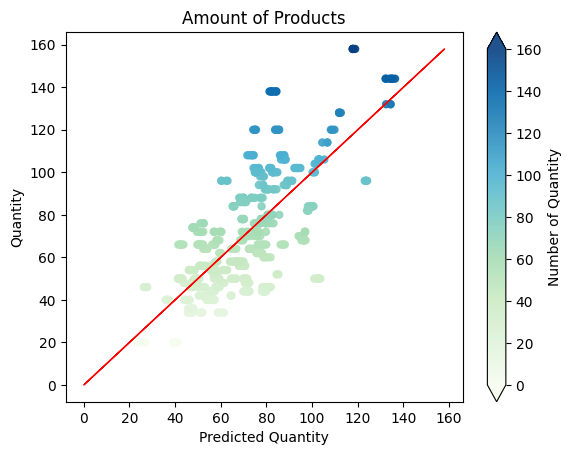

In [116]:
colors = np.interp(y_test_merge["QUANTITY"], (y_test_merge["QUANTITY"].min(), y_test_merge["QUANTITY"].max()), (0, 160))

plt.xlabel("Predicted Quantity")
plt.ylabel("Quantity")
plt.title("Amount of Products")

plt.scatter(x=y_test_merge["PREDICTED_QUANTITY"], y=y_test_merge["QUANTITY"], s=25, c=colors, cmap="GnBu", alpha=0.9)
plt.colorbar(orientation="vertical", label="Number of Quantity", extend="both")
plt.clim(0, 160)

line: Any = np.linspace(y_test_merge["QUANTITY"].min(), y_test_merge["QUANTITY"].max(), 100)
plt.arrow(0, 0, line.max(), line.max(), color="red")
plt.show()

### Measure mean errors for squared and absolute

We berekenen voor beide squared en absolute de error, zodat we kunnen zien hoe goed het model werkt.

In [117]:
mean_squared_error(y_test_merge["QUANTITY"], y_test_merge["PREDICTED_QUANTITY"])

350.5541271181712

In [118]:
mean_absolute_error(y_test_merge["QUANTITY"], y_test_merge["PREDICTED_QUANTITY"])

14.525604941163815